In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import cv2
from torchvision import transforms, utils
from TrainDataset import TrainDataset
from TestDataset import TestDataset
from torch.utils.data import Dataset, DataLoader
from model import ReconNet
import torch.nn as nn
import torch.optim as optim
from time import time

In [13]:
from TrainDataset import TrainDataset
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

# Step 0 : 准备工作

In [2]:
measurement_rate = 0.25
train_data_path = 'BSDS200'
test_data_path = 'General20'
matfn = 'D:/JupyterWorkSpace/None/phi/phi_0_25_1089.mat'
epochs_loss = []
filter_size = 33
stride = 33

## 读入采样矩阵

In [10]:
mat_file = sio.loadmat(matfn)
mat = mat_file['phi']
mat = np.where(mat > 0, 1, -1)
mat = torch.from_numpy(mat)

In [31]:
mat = mat.double()
mat

tensor([[ 1., -1.,  1.,  ..., -1., -1.,  1.],
        [-1., -1.,  1.,  ...,  1., -1.,  1.],
        [ 1.,  1., -1.,  ..., -1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        [-1., -1., -1.,  ..., -1., -1.,  1.]], dtype=torch.float64)

# Step 1 : 数据处理和载入

In [32]:
transformations = transforms.Compose([
    transforms.ToTensor()
])

train_data = TrainDataset(train_data_path, mat, transformations, measurement_rate)
train_dl = DataLoader(train_data, batch_size=256)

In [33]:
train_dl = DataLoader(train_data, batch_size=256)

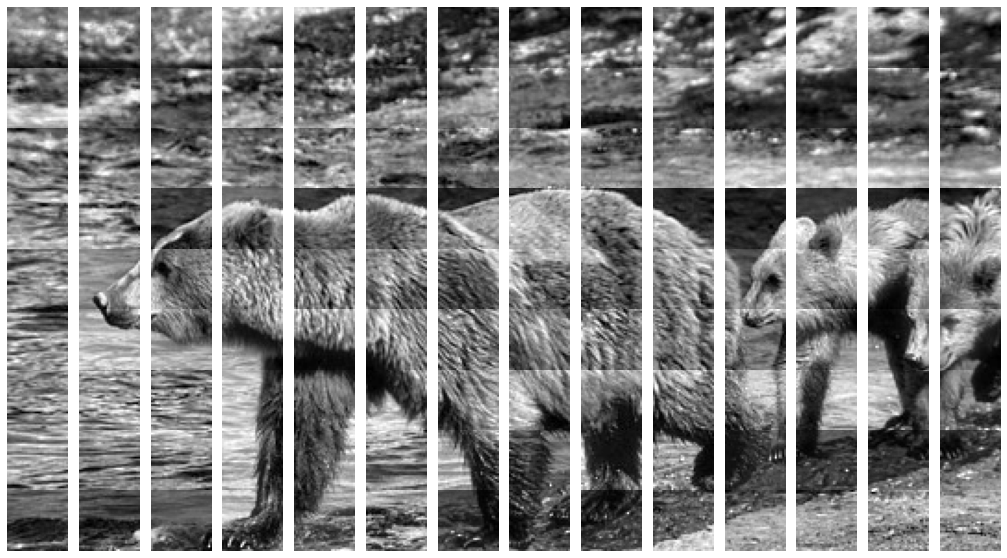

In [20]:
fig, axes = plt.subplots(9, 14, figsize = (18, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
idx = 0
for row in axes:
    for axe in row:
        axe.imshow(train_data.image_blocks[idx], cmap = 'gray')
        idx += 1
        axe.set_axis_off()

In [34]:
train_data.__len__()

25200

# Step 2 : 训练 ReconNet

## 测试 GPU 是否受用

In [35]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 模型准备

In [16]:
ReconNet_model = ReconNet(measurement_rate=0.25)
ReconNet_model = ReconNet_model.cuda()

criterion = nn.MSELoss()
criterion = criterion.cuda()

optimizer = optim.Adam(ReconNet_model.parameters(), lr=0.001)

## 定义训练函数

In [17]:
optimizer = optim.Adam(ReconNet_model.parameters(), lr=0.1)

In [36]:
def train(model, criterion, optimizer, train_dl, num_epochs=10):
    
    epochs_loss = []
    
    for epoch in range(num_epochs):
        # 记录每个 epoch 下的每个 batch 的损失
        batches_loss = 0
        ReconNet_model.train()
        # 开始一个 batch 的训练
        for inp, lbl in train_dl:
            inp = inp.cuda()
            lbl = lbl.cuda()
            inp = inp.float()
            lbl = lbl.float()
            # 梯度清零
            optimizer.zero_grad()
            # 计算结果
            out = model(inp)
            out = out.cuda()
            # 计算损失
            out = out.view(lbl.size())
            loss = criterion(out, lbl)
            loss.backward()
            optimizer.step()
            # 记录每个 batch 的损失
            batches_loss += loss.item()
        
        epochs_loss.append(batches_loss / len(train_dl))
        print('Epoch:', epoch + 1, 'Training Loss:', epochs_loss[epoch])
    
    return epochs_loss


In [37]:
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=9))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 28.63154036167896


37.68296456336975

In [46]:
torch.save(ReconNet_model.state_dict(), 'D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch10.pth')

In [42]:
# lr: 0.01->0.1
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=5))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 0.0626182890128401
Epoch: 2 Training Loss: 0.06148685718683271
Epoch: 3 Training Loss: 0.06152963970650725
Epoch: 4 Training Loss: 0.061541099396775364
Epoch: 5 Training Loss: 0.061545826674339735


144.7893705368042

In [47]:
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=10))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 0.007514146956229451
Epoch: 2 Training Loss: 0.0073425457201371285
Epoch: 3 Training Loss: 0.007600245345854247
Epoch: 4 Training Loss: 0.007121871926379625
Epoch: 5 Training Loss: 0.00731691249853207
Epoch: 6 Training Loss: 0.007344520142809911
Epoch: 7 Training Loss: 0.006879242259369354
Epoch: 8 Training Loss: 0.006738559452280628
Epoch: 9 Training Loss: 0.007027494302489842
Epoch: 10 Training Loss: 0.0068709108145963965


282.1085088253021

In [48]:
torch.save(ReconNet_model.state_dict(), 'D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch20.pth')

In [49]:
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=10))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 0.006538965952149921
Epoch: 2 Training Loss: 0.006515599527358633
Epoch: 3 Training Loss: 0.006764134100516035
Epoch: 4 Training Loss: 0.006478390695216755
Epoch: 5 Training Loss: 0.006354058365986654
Epoch: 6 Training Loss: 0.006327803137317074
Epoch: 7 Training Loss: 0.006322141994270637
Epoch: 8 Training Loss: 0.006296713908221761
Epoch: 9 Training Loss: 0.0063296234848993745
Epoch: 10 Training Loss: 0.005959183872545684


282.5864329338074

In [50]:
torch.save(ReconNet_model.state_dict(), 'D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch30.pth')

In [51]:
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=10))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 0.005972359026076667
Epoch: 2 Training Loss: 0.005943153071160795
Epoch: 3 Training Loss: 0.005814481941710292
Epoch: 4 Training Loss: 0.005880508172052978
Epoch: 5 Training Loss: 0.0062192392881225906
Epoch: 6 Training Loss: 0.00598578064142717
Epoch: 7 Training Loss: 0.0057251135009632565
Epoch: 8 Training Loss: 0.0055625321922090016
Epoch: 9 Training Loss: 0.005536045040700095
Epoch: 10 Training Loss: 0.00551599778136182


282.24390292167664

In [52]:
torch.save(ReconNet_model.state_dict(), 'D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch40.pth')

In [53]:
t1 = time()
epochs_loss.extend(train(ReconNet_model, criterion, optimizer, train_dl, num_epochs=10))
t2 = time()
t = t2 - t1
t

Epoch: 1 Training Loss: 0.005417649997539367
Epoch: 2 Training Loss: 0.00825659347688685
Epoch: 3 Training Loss: 0.005857536416369105
Epoch: 4 Training Loss: 0.005450540673777912
Epoch: 5 Training Loss: 0.0053608588841414515
Epoch: 6 Training Loss: 0.005300533142872155
Epoch: 7 Training Loss: 0.005253597140321602
Epoch: 8 Training Loss: 0.005216294166989474
Epoch: 9 Training Loss: 0.0052043005925217515
Epoch: 10 Training Loss: 0.005157529615157406


285.1235411167145

In [57]:
torch.save(ReconNet_model.state_dict(), 'D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch50.pth')

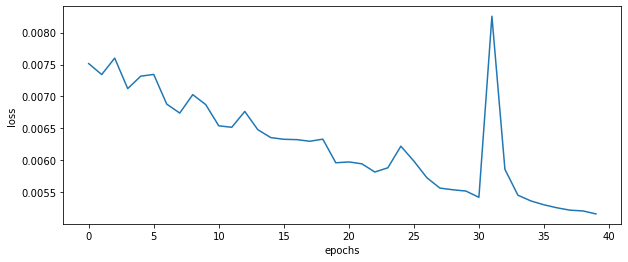

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(range(40), epochs_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Step 3 : 测试ReconNet

## 载入 ReconNet （网络的参数）

In [3]:
ReconNet_model = ReconNet(measurement_rate=0.25)
ReconNet_model = ReconNet_model.cuda()

criterion = torch.nn.MSELoss()
criterion = criterion.cuda()

state_dict = torch.load('D:/JupyterWorkSpace/None/ModelState/model_state_lr0001_b256_mr25_epoch50.pth')
ReconNet_model.load_state_dict(state_dict)
ReconNet_model.eval()

ReconNet(
  (fc1): Linear(in_features=272, out_features=1089, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv5): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)

In [10]:
transformations = transforms.Compose([
    transforms.ToTensor()
])
test_data = TestDataset(test_data_path, mat, transformations, measurement_rate)
test_dl = DataLoader(test_data, batch_size=256)

In [25]:
test_dl = DataLoader(test_data, batch_size=1024, num_workers=0)

In [176]:
test_iter = iter(test_dl)
images, labels = test_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([1024, 272])
torch.Size([1024, 1089])


In [177]:
len(test_dl)

53

In [178]:
def test(model, test_dl):
    recon_blocks = []
    
    with torch.no_grad():
        for inp, lbl in test_dl:
            inp = inp.cuda()
            inp = inp.float()
            
            out = ReconNet_model(inp)
            
            #out = out.cuda()
            out = out.view(lbl.size())
            
            # out 是 batch_size × (filter_size * filter_size) 的块，通过 extend 方法，将批次解开，作为独立的块存储
            
            recon_blocks.extend(out)
            
    return recon_blocks

In [12]:
def testDL(test_dl):
    t1 = time()
    for inp, lbl in test_dl:
        print("read cost : ", time() - t1)
        t1 = time()


## 测试

In [6]:
t1 = time()
out = []
out = test(ReconNet_model, test_dl)
t2 = time()
t = t2 - t1
t

NameError: name 'test_dl' is not defined

In [26]:
t1 = time()
testDL(test_dl)
t2 = time()
t = t2 - t1
t

read cost :  0.12282443046569824
read cost :  0.10771346092224121
read cost :  0.09973311424255371
read cost :  0.11170101165771484
read cost :  0.09973287582397461
read cost :  0.09924197196960449
read cost :  0.0967409610748291
read cost :  0.1765296459197998
read cost :  0.2513148784637451
read cost :  0.08377504348754883


1.259289264678955

In [180]:
# 块数
len(out)

54006

In [181]:
t/len(out)

0.00024060813099420703

In [182]:
for i in range(len(out)):
    out[i] = out[i].view(filter_size, filter_size)
    out[i] = out[i].cpu()
    out[i] = out[i].detach().numpy()


In [183]:
out[0].shape

(33, 33)

## 拼接图像

In [184]:
def spliceImg(img_path, out, channels=3):
    # 先获取原始图像的分块数量
    test_img_list = os.listdir(img_path)
    test_img_block_size_list = []
    for img_name in test_img_list:
        image = plt.imread(os.path.join(img_path, img_name))
        h, w, _ = image.shape
        h_n = ((h - filter_size) // stride) + 1
        w_n = ((w - filter_size) // stride) + 1
        #print(h, w, ' : ', h_n, w_n)
        test_img_block_size_list.append((h_n, w_n))
    
    # 根据每张图片的分块数量，拼接重建图像
    recon_img_list = []
    k = 0
    for (h_n, w_n) in test_img_block_size_list:
        h = (h_n - 1) * stride + filter_size
        w = (w_n - 1) * stride + filter_size
        recon_img = np.zeros((h, w))
        recon_img_channels = []
        
        for c in range(channels):
            
            for i in range(h_n):
                for j in range(w_n):
                    recon_img[i * stride : (i * stride) + filter_size, j * stride : (j * stride) + filter_size] = out[k]
                    k += 1
            recon_img_channels.append(recon_img)
        # 集三个通道的数据做一张重建图像
        recon_img_list.append(np.array(recon_img_channels))
    
    return recon_img_list

In [185]:
recon_img_list = spliceImg(test_data_path, out)

#### (c, h, w) 转化为 (h, w, c)

In [186]:
for i in range(len(recon_img_list)):
    recon_img_list[i] = recon_img_list[i].transpose((1, 2, 0))

In [187]:
recon_img_list[0].shape

(201, 271, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


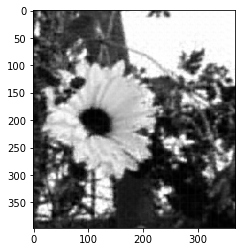

In [192]:
plt.imshow(recon_img_list[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


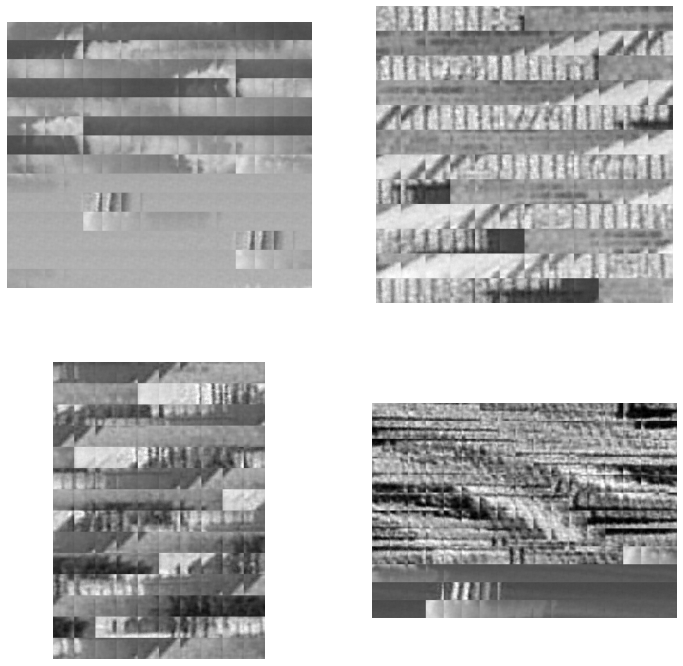

In [112]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))

for row in axes:
    for axe in row:
        idx = np.random.randint(len(os.listdir(test_data_path)))
        # 在画布相应位置展示图片
        axe.imshow(recon_img_list[idx])
        axe.set_axis_off()

## 跑一下训练集的数据试一下

In [126]:
test_data = TestDataset(train_data_path, mat, transformations, measurement_rate)
test_dl = DataLoader(test_data, batch_size=256)

out = test(ReconNet_model, test_dl)

for i in range(len(out)):
    out[i] = out[i].view(filter_size, filter_size)
    out[i] = out[i].cpu()
    out[i] = out[i].detach().numpy()

recon_img_list = spliceImg(test_data_path, out)
for i in range(len(recon_img_list)):
    recon_img_list[i] = recon_img_list[i].transpose((1, 2, 0))
    


210 283  :  6 8
413 582  :  12 17
340 343  :  10 10
468 451  :  14 13
440 399  :  13 12
354 356  :  10 10
480 549  :  14 16
462 500  :  14 15
378 406  :  11 12
516 526  :  15 15
407 380  :  12 11
424 524  :  12 15
481 585  :  14 17
518 648  :  15 19
412 487  :  12 14
420 448  :  12 13
426 400  :  12 12
492 348  :  14 10
460 468  :  13 14
455 390  :  13 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


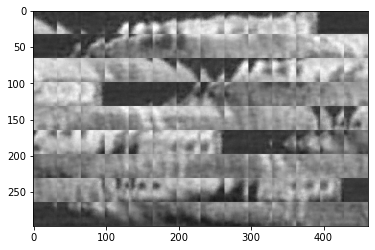

In [128]:
plt.imshow(recon_img_list[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


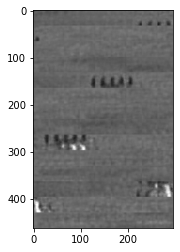

In [129]:
plt.imshow(recon_img_list[80])